In [ ]:
### Amino acids

In [1]:
# Mount google drive at /content/drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json

data_file_path = "/content/drive/MyDrive/protein_props/protein_props.json"
druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/druggable_proteins.txt"
approved_druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/approved_druggable_proteins.txt"

with open(data_file_path, 'r') as f:
    protein_data = json.load(f)

print("Total number of uniprot human verified proteins:", len(protein_data))


Total number of uniprot human verified proteins: 20434


In [3]:
with open(druggable_proteins_file_path, 'r') as f:
    druggable_proteins = f.read().splitlines()

with open(approved_druggable_proteins_file_path, 'r') as f:
    approved_druggable_proteins = f.read().splitlines()

print("Number of druggable proteins:", len(druggable_proteins))
print("Number of approved druggable proteins:", len(approved_druggable_proteins))

Number of druggable proteins: 3345
Number of approved druggable proteins: 2652


In [4]:
max_seq_length = -1
min_seq_length = 1e10

for protein in protein_data:
  seq_length = len(protein_data[protein]['Sequence'])
  max_seq_length = max(max_seq_length, seq_length)
  min_seq_length = min(min_seq_length, seq_length)

print("Maximum Sequence Length:", max_seq_length)
print("Minimum Sequence Length:", min_seq_length)

Maximum Sequence Length: 34350
Minimum Sequence Length: 2


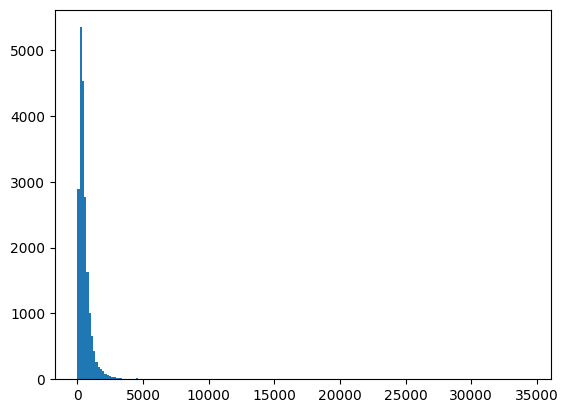

In [5]:
# Distribution of sequence lengths, plot a histogram

import matplotlib.pyplot as plt

plt.hist([len(protein_data[protein]['Sequence']) for protein in protein_data], bins=200)
plt.show()

In [6]:
def find_num_proteins_between(MIN_LENGTH, MAX_LENGTH):
  druggable_protein_count = 0
  non_druggable_protein_count = 0
  for protein in protein_data:
    if MIN_LENGTH <= len(protein_data[protein]['Sequence']) <= MAX_LENGTH:
      if protein in druggable_proteins:
        druggable_protein_count += 1
      else:
        non_druggable_protein_count += 1
  print("Number of proteins between", MIN_LENGTH, "and", MAX_LENGTH, ":", druggable_protein_count + non_druggable_protein_count)
  print("Number of druggable proteins between", MIN_LENGTH, "and", MAX_LENGTH, ":", druggable_protein_count)
  print("Number of non-druggable proteins between", MIN_LENGTH, "and", MAX_LENGTH, ":", non_druggable_protein_count)

In [7]:
find_num_proteins_between(min_seq_length, 3000)

Number of proteins between 2 and 3000 : 20273
Number of druggable proteins between 2 and 3000 : 3324
Number of non-druggable proteins between 2 and 3000 : 16949


In [8]:
find_num_proteins_between(min_seq_length, max_seq_length)

Number of proteins between 2 and 34350 : 20434
Number of druggable proteins between 2 and 34350 : 3345
Number of non-druggable proteins between 2 and 34350 : 17089


In [9]:
# Find unique amino acids in protein sequences
unique_amino_acids = set()
for protein in protein_data:
    seq = protein_data[protein]['Sequence']
    for aa in seq:
        unique_amino_acids.add(aa)

print("Number of unique amino acids:", len(unique_amino_acids))
print(unique_amino_acids)

Number of unique amino acids: 20
{'R', 'S', 'T', 'N', 'K', 'Q', 'C', 'L', 'D', 'M', 'I', 'E', 'V', 'F', 'A', 'Y', 'P', 'W', 'H', 'G'}


In [10]:
unique_amino_acids = sorted(list(unique_amino_acids))
print(unique_amino_acids)

amino_acid_to_num_mapping = {aa: i+1 for i, aa in enumerate(unique_amino_acids)}
print(amino_acid_to_num_mapping)

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}


In [32]:
def get_data_protein_sequence_encoding(MIN_LENGTH, MAX_LENGTH):
  valid_length_proteins = {}
  for protein in protein_data:
    if MIN_LENGTH <= len(protein_data[protein]['Sequence']) <= MAX_LENGTH:
      seq = protein_data[protein]['Sequence']
      encoded_seq = [amino_acid_to_num_mapping[aa] for aa in seq]
      valid_length_proteins[protein] = encoded_seq
  print("Total data length: ", len(valid_length_proteins))
  return valid_length_proteins

def fill_repeat_protein(amino_acid_encoded_sequences):
  final_sequences = []
  for seq in amino_acid_encoded_sequences:
    # length of sequence is uptil when the value is not zero
    length = 0
    for i in seq:
      if i == 0: break
      else: length += 1
    new_seq = []
    # fill seq and repeat as many times with a 0 single gap in between
    while(len(new_seq) <= len(seq)):
      new_seq.extend(seq[:length])
      new_seq.append(0)
    final_sequences.append(new_seq[:3000])
  return final_sequences


In [33]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

def sequence_process(sequences, max_length):
  processed_sequences = []
  count = 0
  for seq in sequences:
    seq = seq + [0] * (max_length - len(seq))
    assert len(seq) == max_length
    processed_sequences.append(seq)
    count += 1
    if count % 1000 == 0:
      print(count, "sequences processed")
  return processed_sequences

def train_test_split_(MIN_LIMIT, MAX_LIMIT, druggable_proteins, test_size=0.2, case_ = 'default', shuffle = True, fill_repeat = False):
  protein_data_combined = get_data_protein_sequence_encoding(MIN_LIMIT, MAX_LIMIT)
  druggable_proteins_data = [protein_data_combined[protein] for protein in protein_data_combined if protein in druggable_proteins]
  non_druggable_proteins_data = [protein_data_combined[protein] for protein in protein_data_combined if protein not in druggable_proteins]
  print("Number of druggable to non druggable = ", len(druggable_proteins_data), ":", len(non_druggable_proteins_data))
  X_druggable = druggable_proteins_data
  X_non_druggable = non_druggable_proteins_data
  X_druggable = sequence_process(X_druggable, MAX_LIMIT)
  X_non_druggable = sequence_process(X_non_druggable, MAX_LIMIT)
  if case_ == "oversampling":
    X_druggable = [random.choice(X_druggable) for _ in range(len(X_non_druggable))]
  if case_ == "undersampling":
    X_non_druggable = [random.choice(X_non_druggable) for _ in range(len(X_druggable))]

  print("Number of druggable to non druggable = ", len(X_druggable), ":", len(X_non_druggable))
  X_combined = X_druggable + X_non_druggable
  if(fill_repeat): X_combined = fill_repeat_protein(X_combined)
  y_combined = [1] * len(X_druggable) + [0] * len(X_non_druggable)
  if shuffle:
    combined = list(zip(X_combined, y_combined))
    random.shuffle(combined)
    X_combined, y_combined = zip(*combined)
  X_combined = np.array(X_combined)
  y_combined = np.array(y_combined)
  X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=test_size, stratify=y_combined, random_state = 42)
  return X_train, X_test, y_train, y_test



In [57]:
X_train, X_test, y_train, y_test = train_test_split_(2,3000, druggable_proteins, test_size=0.2, case_='oversampling', shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Total data length:  20273
Number of druggable to non druggable =  3324 : 16949
1000 sequences processed
2000 sequences processed
3000 sequences processed
1000 sequences processed
2000 sequences processed
3000 sequences processed
4000 sequences processed
5000 sequences processed
6000 sequences processed
7000 sequences processed
8000 sequences processed
9000 sequences processed
10000 sequences processed
11000 sequences processed
12000 sequences processed
13000 sequences processed
14000 sequences processed
15000 sequences processed
16000 sequences processed
Number of druggable to non druggable =  16949 : 16949
(27118, 3000) (6780, 3000) (27118,) (6780,)


In [58]:
# Distribution of druggable/nondruggable in test and train
print("Train distribution:", sum(y_train==1), sum(y_train==0))
print("Test distribution:", sum(y_test==1), sum(y_test==0))

Train distribution: 13559 13559
Test distribution: 3390 3390


In [59]:
# Train a neural network with this data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Dataloader class
class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.X)
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

# Define the neural network
class Neural_Network(nn.Module):
  def __init__(self, input_size, hidden_size, num_hidden_layers):
    super(Neural_Network, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    # num_hidden_layers of linear and relu
    self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
    self.hidden_relus = nn.ModuleList([nn.ReLU() for _ in range(num_hidden_layers)])
    self.fc2 = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    for layer, relu in zip(self.hidden_layers, self.hidden_relus):
      x = layer(x)
      x = relu(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

In [60]:
train_loader = DataLoader(MyDataset(X_train, y_train), batch_size=512, shuffle=True)
test_loader = DataLoader(MyDataset(X_test, y_test), batch_size=512, shuffle=False)

In [61]:
# Train loop
def train_network(model, train_loader, test_loader, num_epochs, learning_rate, test_loss_step):
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_losses = []
  test_losses = []
  best_train_loss = 1e10
  best_test_loss = 1e10
  best_test_accuracy = 0
  best_train_model = None
  best_test_model_on_loss = None
  best_test_model_on_accuracy = None

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs.float())
      loss = criterion(outputs.squeeze(), labels.float())
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')
    train_losses.append(train_loss)
    if train_loss < best_train_loss:
      best_train_loss = train_loss
      best_train_model = model

    if (epoch+1) % test_loss_step == 0:
      model.eval()
      test_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
        for inputs, labels in test_loader:
          outputs = model(inputs.float())
          loss = criterion(outputs.squeeze(), labels.float())
          test_loss += loss.item()
          predicted = (outputs.squeeze() > 0.5).long()
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      test_loss /= len(test_loader)
      accuracy = 100 * correct / total
      print(f'***Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
      test_losses.append(test_loss)
      if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_test_model_on_loss = model
      if accuracy > best_test_accuracy:
        best_test_accuracy = accuracy
        best_test_model_on_accuracy = model


  return train_losses, test_losses, best_train_model, best_test_model_on_loss, best_test_model_on_accuracy



In [62]:
model = Neural_Network(input_size=3000, hidden_size=128, num_hidden_layers=4)
train_losses, test_losses, best_train_model, best_test_model_on_loss, best_test_model_on_accuracy = train_network(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001, test_loss_step =1)

Epoch [1/50], Train Loss: 0.6877
***Epoch [1/50], Test Loss: 0.6839, Accuracy: 55.44%
Epoch [2/50], Train Loss: 0.6783
***Epoch [2/50], Test Loss: 0.6714, Accuracy: 58.50%
Epoch [3/50], Train Loss: 0.6599
***Epoch [3/50], Test Loss: 0.6655, Accuracy: 59.51%
Epoch [4/50], Train Loss: 0.6256
***Epoch [4/50], Test Loss: 0.6533, Accuracy: 61.15%
Epoch [5/50], Train Loss: 0.5962
***Epoch [5/50], Test Loss: 0.6255, Accuracy: 62.82%
Epoch [6/50], Train Loss: 0.5642
***Epoch [6/50], Test Loss: 0.5929, Accuracy: 66.53%
Epoch [7/50], Train Loss: 0.5409
***Epoch [7/50], Test Loss: 0.6078, Accuracy: 66.53%
Epoch [8/50], Train Loss: 0.5184
***Epoch [8/50], Test Loss: 0.5863, Accuracy: 68.42%
Epoch [9/50], Train Loss: 0.5074
***Epoch [9/50], Test Loss: 0.5829, Accuracy: 69.94%
Epoch [10/50], Train Loss: 0.4655
***Epoch [10/50], Test Loss: 0.5592, Accuracy: 72.33%
Epoch [11/50], Train Loss: 0.4398
***Epoch [11/50], Test Loss: 0.5145, Accuracy: 75.59%
Epoch [12/50], Train Loss: 0.4049
***Epoch [12/50]

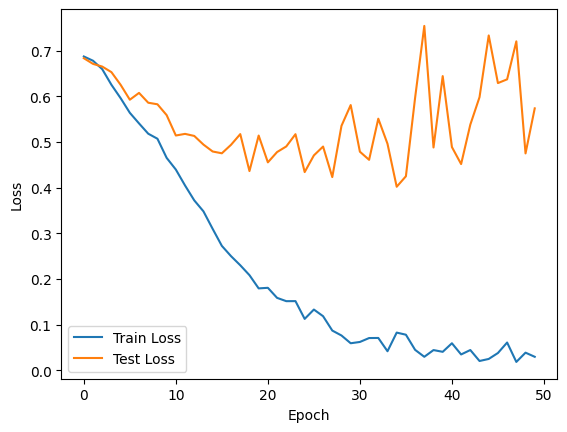

In [63]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import roc_auc_score, confusion_matrix

def evaluate(trained_model, dataloader):
  trained_model.eval()

  y_pred = []
  y_true = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      outputs = trained_model(inputs.float())
      predicted = (outputs.squeeze() > 0.5).long()
      y_pred.extend(predicted.tolist())
      y_true.extend(labels.tolist())

  accuracy = 100 * sum([1 if y_pred[i]==y_true[i] else 0 for i in range(len(y_pred))]) / len(y_pred)
  roc_auc = roc_auc_score(y_true, y_pred)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  specificity = tn / (tn + fp)
  sensitivity = tp / (tp + fn)

  return accuracy, roc_auc, specificity, sensitivity

In [65]:
def print_metrics(trained_model, dataloader, name):
  accuracy, roc_auc, specificity, sensitivity = evaluate(trained_model, dataloader)
  print(f"""{name} Metrics:
  Accuracy: {accuracy:.2f}%
  ROC AUC: {roc_auc:.4f}
  Specificity: {specificity:.4f}
  Sensitivity: {sensitivity:.4f}""")


In [66]:
# Best train model
print_metrics(best_train_model, train_loader, "Best Train Model on Training Data")
print_metrics(best_train_model, test_loader, "Best Train Model on Test Data")
# Best test model on loss
print_metrics(best_test_model_on_loss, train_loader, "Best Test Model on Loss on Training Data")
print_metrics(best_test_model_on_loss, test_loader, "Best Test Model on Loss on Test Data")
# Best test model on accuracy
print_metrics(best_test_model_on_accuracy, train_loader, "Best Test Model on Accuracy on Training Data")
print_metrics(best_test_model_on_accuracy, test_loader, "Best Test Model on Accuracy on Test Data")


Best Train Model on Training Data Metrics:
  Accuracy: 99.65%
  ROC AUC: 0.9965
  Specificity: 0.9952
  Sensitivity: 0.9978
Best Train Model on Test Data Metrics:
  Accuracy: 91.46%
  ROC AUC: 0.9146
  Specificity: 0.8466
  Sensitivity: 0.9826
Best Test Model on Loss on Training Data Metrics:
  Accuracy: 99.65%
  ROC AUC: 0.9965
  Specificity: 0.9952
  Sensitivity: 0.9978
Best Test Model on Loss on Test Data Metrics:
  Accuracy: 91.46%
  ROC AUC: 0.9146
  Specificity: 0.8466
  Sensitivity: 0.9826
Best Test Model on Accuracy on Training Data Metrics:
  Accuracy: 99.65%
  ROC AUC: 0.9965
  Specificity: 0.9952
  Sensitivity: 0.9978
Best Test Model on Accuracy on Test Data Metrics:
  Accuracy: 91.46%
  ROC AUC: 0.9146
  Specificity: 0.8466
  Sensitivity: 0.9826


In [67]:
# save best_train_model to drive
torch.save(best_train_model.state_dict(), '/content/drive/MyDrive/protein_props/best_train_model.pth')